In [1]:
%cd cache-prefetchers
! pip install sympy
from IPython import get_ipython

def git_pull():
    !git pull > /dev/null

get_ipython().events.register('pre_run_cell', git_pull)


/notebooks/cache-prefetchers


In [148]:
%load_ext autoreload
%autoreload 3


import matplotlib.pyplot as plt
import numpy as np
from typing import List, Tuple, Set
import abc
import torch
import dataclasses
import pandas as pd
import os
import copy
import time
import tqdm
from opt import opt_cache_simulation


from cache import Cache
from eviction import LRU, DOM, MQ, RandomEvictor
from prefetch import Next, Markov, EnsamblePrefetcher
from prob_model import FFM
from markov_generator import RandomMarkovGenerator
from fieldfm import train_ffm, FieldAwareFactorizationMachine, FieldAwareFactorizationMachineModel


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
@dataclasses.dataclass
class TestResult:

    cache_name: str
    miss_count: int
    trace_length: int
    unique_addresses: int
    execution_time: float


    def __repr__(self) -> str:
        return (
            f"Cache name: {self.cache_name}\n"
            f"Miss count: {self.miss_count}\n"
            f"Trace length: {self.trace_length}\n"
            f"Unique addresses: {self.unique_addresses}\n"
            f"Miss rate: {self.miss_count / self.trace_length}\n"
            f"Execution time: {self.execution_time}"
        )



def test_cache(cache: Cache, requests: List[int]) -> TestResult:
    """Returns cache miss count for given cache and requests."""
    cache = copy.deepcopy(cache)
    time_start = time.time()

    misses = 0
    for r in tqdm.tqdm(requests):
        if not cache.read(r):
            misses += 1

    time_end = time.time()

    return TestResult(
        cache_name=cache.name,
        miss_count=misses,
        trace_length=len(requests),
        unique_addresses=len(set(requests)),
        execution_time=time_end - time_start,
    )


def get_opt_for_sequence(sequence: list[int], cache_size=8) -> TestResult:
    total_length = 0
    unique_addresses = set()

    unique_addresses.update(sequence)

    misses = opt_cache_simulation(sequence, cache_size)

    return TestResult(
        cache_name="OPT",
        miss_count=misses,
        unique_addresses=len(set(unique_addresses)),
        trace_length=total_length,
        execution_time=None
    )

def test_markov_sequences(caches: List[Cache], sequences: List[List[int]], cache_size: int):
    file_name = f"markov_sequences_{cache_size}.csv"

    if os.path.exists(file_name):
        res = pd.read_csv(file_name, index_col=0)
    else:
        res = pd.DataFrame()

    for i, seq in enumerate(sequences):
        if not (len(res) > 0 and len(res[(res['cache'] == 'OPT') & (res['seq'] == i)]) > 0):
            opt_res = get_opt_for_sequence(seq, cache_size)
            new_row = pd.DataFrame([{
                'seq': i,
                'cache': 'OPT',
                'miss_count': opt_res.miss_count,
                'trace_length': opt_res.trace_length,
                'unique_addresses': opt_res.unique_addresses,
                'execution_time': opt_res.execution_time
            }])
            res = pd.concat([res, new_row])
            res.to_csv(file_name)

        for cache in caches:
            if len(res) > 0 and len(res[(res['cache'] == cache.name) & (res['seq'] == i)]) > 0:
                continue

            print("=======================================")
            print(f"Sequence {i}, cache: {cache.name}")
            print("=======================================")
            try:
                test_result = test_cache(cache, seq)
            except Exception as exc:
                print("ERROR", exc)
                continue

            new_row = pd.DataFrame([{
                'seq': i,
                'cache': cache.name,
                'miss_count': test_result.miss_count,
                'trace_length': test_result.trace_length,
                'unique_addresses': test_result.unique_addresses,
                'execution_time': test_result.execution_time
            }])
            res = pd.concat([res, new_row])
            res.to_csv(file_name)

    res['miss_rate'] = res['miss_count'] / res['trace_length']
    res = res.sort_values(by=['seq', 'miss_rate'])

    return res


In [47]:
SEQ_LEN = 50000
N = 10  # Address space size
SEQ_COUNT = 3  # Number of sequences to generate
CACHE_SIZE = 16
generator = RandomMarkovGenerator(N)
sequences = [
    generator.generate_sequence(SEQ_LEN)
    for _ in range(SEQ_COUNT)
]


In [48]:
print(generator.transition_matrix)

[[0.09829626 0.03500113 0.02446128 0.09607353 0.19375179 0.05405691
  0.14833168 0.15312208 0.01619671 0.18070863]
 [0.14091671 0.06569584 0.04420682 0.187211   0.04003529 0.19230812
  0.16754346 0.00300972 0.00729082 0.15178223]
 [0.10067302 0.02432985 0.12591897 0.0295735  0.20395507 0.15519258
  0.11003065 0.01295312 0.04956194 0.1878113 ]
 [0.07921192 0.08396095 0.1040151  0.17243183 0.14145707 0.12925679
  0.02889677 0.14674182 0.02368155 0.09034619]
 [0.1596687  0.03369768 0.01085821 0.19892187 0.00772564 0.1879061
  0.06558215 0.10969126 0.16496173 0.06098667]
 [0.11297928 0.02810801 0.02844043 0.08676153 0.1736365  0.01252974
  0.21125752 0.06723754 0.1630608  0.11598867]
 [0.11019935 0.00327729 0.19127701 0.11175201 0.20480128 0.15406843
  0.05749952 0.03880832 0.05679795 0.07151884]
 [0.11149179 0.11099472 0.22332367 0.08369271 0.04652892 0.02777586
  0.01574712 0.12392985 0.03034505 0.22617031]
 [0.09868014 0.02337528 0.14649152 0.06588238 0.05857646 0.1195899
  0.13270889 0

In [6]:
import random

from scipy import optimize
from fieldfm import FieldAwareFactorizationMachineModel
from torch import ge
n_samples = 100000
real_probs = []
target = []
N = 10

x = []
for i in range(n_samples):
    h = np.random.randint(0, N)
    a, b = random.sample(range(N), 2)
    r = random.random()

    if r < generator.transition_matrix[h][a]:
        y = 1
    else:
        y = 0

    x.append([h, a, b])
    target.append(y)
    real_probs.append(generator.transition_matrix[h][a])

NameError: name 'generator' is not defined

Real transition matrix
[[0.09829626 0.03500113 0.02446128 0.09607353 0.19375179 0.05405691
  0.14833168 0.15312208 0.01619671 0.18070863]
 [0.14091671 0.06569584 0.04420682 0.187211   0.04003529 0.19230812
  0.16754346 0.00300972 0.00729082 0.15178223]
 [0.10067302 0.02432985 0.12591897 0.0295735  0.20395507 0.15519258
  0.11003065 0.01295312 0.04956194 0.1878113 ]
 [0.07921192 0.08396095 0.1040151  0.17243183 0.14145707 0.12925679
  0.02889677 0.14674182 0.02368155 0.09034619]
 [0.1596687  0.03369768 0.01085821 0.19892187 0.00772564 0.1879061
  0.06558215 0.10969126 0.16496173 0.06098667]
 [0.11297928 0.02810801 0.02844043 0.08676153 0.1736365  0.01252974
  0.21125752 0.06723754 0.1630608  0.11598867]
 [0.11019935 0.00327729 0.19127701 0.11175201 0.20480128 0.15406843
  0.05749952 0.03880832 0.05679795 0.07151884]
 [0.11149179 0.11099472 0.22332367 0.08369271 0.04652892 0.02777586
  0.01574712 0.12392985 0.03034505 0.22617031]
 [0.09868014 0.02337528 0.14649152 0.06588238 0.05857646 0

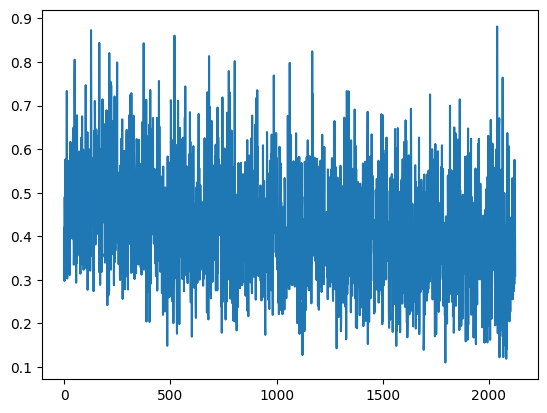

In [50]:
model = FieldAwareFactorizationMachineModel([N]*3, 8)
real_probs = torch.tensor(real_probs, dtype=torch.float32)
#target = real_probs
target = torch.tensor(target, dtype=torch.float32)
x = torch.tensor(x, dtype=torch.long)

optimizer = torch.optim.Adagrad(model.parameters(), lr=5e-3, weight_decay=5e-4)
criterion = torch.nn.BCELoss()
batch_size = 32
losses = []
for i in range(n_samples//batch_size):
    batch_x = x[i*batch_size:(i+1)*batch_size]
    batch_y = target[i*batch_size:(i+1)*batch_size]


    output = model(batch_x)
    loss = criterion(output, batch_y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    losses.append(loss.item())


learned_transition_matrix = np.zeros((N, N))
for a in range(N):
    for b in range(N):
        learned_transition_matrix[a][a] = model(torch.tensor([[a, a, b]]))[0].item()
        learned_transition_matrix[a][b] = model(torch.tensor([[a, b, b]]))[0].item()


print("Real transition matrix")
print(generator.transition_matrix)

print("Learned transition matrix")
print(learned_transition_matrix)

print(losses[-1])
plt.plot(losses[1000:])

In [232]:
generator = RandomMarkovGenerator(32)
requests = generator.generate_sequence(50000)
print(generator.transition_matrix)

[[0.03421354 0.03642507 0.02115866 ... 0.01022481 0.0371022  0.04029498]
 [0.02925908 0.06237806 0.01625547 ... 0.01174818 0.01805824 0.01307065]
 [0.01846881 0.0501551  0.01592541 ... 0.01752975 0.05048043 0.02578443]
 ...
 [0.03477859 0.0634959  0.04073831 ... 0.01948571 0.04454362 0.02462597]
 [0.0296042  0.03826438 0.00545807 ... 0.01743923 0.02255313 0.05179763]
 [0.03552741 0.01995579 0.01580646 ... 0.03945924 0.02066863 0.02805857]]


In [270]:


from distr_dom import test_on_sequence as test_on_sequence_dom
config = dict(
    cache_size=16, greedy=False, history_size=1, n_pages=32, hidden_size=128,
    n_deltas=2048, emb_size=8, delta_emb_size=32, lr=5e-2, train_interval=100,
    batch_size=32, train_samples=1000, train_next_delta=False, hash_mapping=True,
    model_class='ffm', wd=1e-4,
)
misses, misses_history, losses, evict_counts, model = test_on_sequence_dom(requests, **config)

print(misses)


Misses: 0, Loss p(a,b): 0, Loss delta: 0, Random loss: 0:   0%|          | 20/50000 [00:00<00:20, 2429.86it/s]


RuntimeError: only Tensors of floating point dtype can require gradients

In [216]:
print(model([1], [0], [1], [0], [0], [0]))

tensor([0.5220], grad_fn=<SigmoidBackward0>)


In [16]:
import random
from distr import test_on_sequence

misses, losses = test_on_sequence(sequences[0], CACHE_SIZE, N, greedy=False, history_size=2)

print(misses)
plt.plot(losses)


NameError: name 'sequences' is not defined

In [234]:
random_cache = Cache(
    name="RandomEvictor",
    eviction_strategy=RandomEvictor(),
    size=CACHE_SIZE
)
random_cache = copy.deepcopy(random_cache)
test_res = test_cache(random_cache, requests)
print(test_res)


AttributeError: type object 'datetime.time' has no attribute 'time'

In [24]:
caches = [
    Cache(
        name="RandomEvictor",
        eviction_strategy=RandomEvictor(),
        size=CACHE_SIZE
    ),
    Cache(
        name="LRU",
        eviction_strategy=LRU(),
        size=CACHE_SIZE
    ),
    Cache(
        name="MQ",
        eviction_strategy=MQ(),
        size=CACHE_SIZE
    ),
    Cache(
        name="MQ + MARKOV(3)",
        eviction_strategy=MQ(),
        prefetch_strategy=Markov(3),
        size=CACHE_SIZE
    ),
    Cache(
        name="DOM(FFM(n=N, h=1, k=10))",
        eviction_strategy=DOM(FFM(n=N, h=1, k=10, my_ffm=False), train_interval=50),
        size=CACHE_SIZE
    ),
    Cache(
        name="RandomEvictor + NEXT",
        eviction_strategy=RandomEvictor(),
        prefetch_strategy=Next(),
        size=CACHE_SIZE
    ),
    Cache(
        name="LRU + NEXT",
        eviction_strategy=LRU(),
        prefetch_strategy=Next(),
        size=CACHE_SIZE
    ),
    Cache(
        name="MQ + NEXT",
        eviction_strategy=MQ(),
        prefetch_strategy=Next(),
        size=CACHE_SIZE
    ),
    Cache(
        name="DOM(FFM(n=N, h=14, k=10)) + NEXT",
        eviction_strategy=DOM(FFM(n=N, h=14, k=10), train_interval=50),
        prefetch_strategy=Next(),
        size=CACHE_SIZE
    ),
    Cache(
        name="RandomEvictor + MARKOV(3)",
        eviction_strategy=RandomEvictor(),
        prefetch_strategy=Markov(3),
        size=CACHE_SIZE
    ),
    Cache(
        name="LRU + MARKOV(3)",
        eviction_strategy=LRU(),
        prefetch_strategy=Markov(3),
        size=CACHE_SIZE
    ),
    Cache(
        name="DOM(FFM(n=N, h=14, k=10)) + MARKOV(3)",
        eviction_strategy=DOM(FFM(n=N, h=14, k=10)),
        prefetch_strategy=Markov(3),
        size=CACHE_SIZE
    ),
][:4]


import itertools
H = [1]
K = [10]
TRAIN_INTERVAL = [50]
SAMPLES = [400]
EPOCHS = [2]
WD = [0.1]
LR = [0.001, 0.01]
WITH_NEUTRAL = [True, False]


grid = itertools.product(
    H, K, TRAIN_INTERVAL, SAMPLES, EPOCHS, WD, LR, WITH_NEUTRAL
)

for h, k, train_interval, samples, epochs, wd, lr, with_neutral in grid:
    name = (
        f"DOM(FFM("
        f"n=N "
        f"h={h} "
        f"k={k} "
        f"e_s={samples} "
        f"t_i={train_interval} "
        f"e={epochs} "
        f"lr={lr} "
        f"wd={wd} "
        f"neutral={with_neutral}"
        "))"
    )

    cache = Cache(
        name=name,
        eviction_strategy=DOM(
            FFM(
                n=N, h=h, k=k, epoch_samples=samples, lr=lr, wd=wd, epochs=epochs,
                with_neutral=with_neutral
            ),
            train_interval=train_interval
        ),
        size=CACHE_SIZE
    )
    caches.append(cache)

pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
test_markov_sequences(caches, sequences, CACHE_SIZE)

Sequence 1, cache: DOM(FFM(n=N h=1 k=10 e_s=400 t_i=50 e=2 lr=0.001 wd=0.1 neutral=False))


100%|██████████| 50000/50000 [05:13<00:00, 159.61it/s]


Sequence 1, cache: DOM(FFM(n=N h=1 k=10 e_s=400 t_i=50 e=2 lr=0.01 wd=0.1 neutral=True))


100%|██████████| 50000/50000 [05:13<00:00, 159.54it/s]


Sequence 1, cache: DOM(FFM(n=N h=1 k=10 e_s=400 t_i=50 e=2 lr=0.01 wd=0.1 neutral=False))


 18%|█▊        | 8970/50000 [00:59<04:30, 151.69it/s]


KeyboardInterrupt: 

# Tests on HUAWEI traces

In [2]:
from hwi_dataset import read_trace, get_test_set, get_reads, get_hwi_page_requests
from collections import defaultdict
test_set = get_test_set()

values = defaultdict(int)

times = []
all_length = 0
test_dir = '2'
all_unique = set()
all_unique_pages = 0
all_pages_length = 0

for v, volume in enumerate(test_set[test_dir]):
    print("volume", v)

    times_volume = []
    unique_volume = set()
    length_volume = 0
    unique_pages_volume = set()
    length_pages_volume = 0
    obj_ids = set()
    for p, path in enumerate(volume):
        print("path", path)
        trace = read_trace(test_set[test_dir][v][p])
        reads = trace[trace['tp'] == 'READ']
        print(reads['volumeId'].unique())

        times_volume.extend(list(reads['last time nano'].values))
        unique_volume.update(reads['objLba'].unique())

        length_volume += len(reads)

        print('length path', len(reads))

        pages = get_hwi_page_requests(get_reads(read_trace(path)), page_size=16*1024)
        unique_pages_path = len(set(pages))
        unique_pages_volume.update(set(pages))
        length_pages_volume += len(pages)
        print('unique pages within path', unique_pages_path)

        obj_ids.update(reads['objId'].unique())
        print("=======================================\n")

    print("volume unique objId", obj_ids)
    print('is times sorted within volume?' , all(times_volume[i] <= times_volume[i+1] for i in range(len(times_volume)-1)))
    print('unique addresses within volume', len(unique_volume))
    print('length volume', length_volume)
    print('pages length volume', length_pages_volume)
    print('unique pages within volume', len(unique_pages_volume))

    times.extend(times_volume)
    all_unique.update(unique_volume)
    all_length += length_volume
    all_unique_pages += len(unique_pages_volume)
    all_pages_length += length_pages_volume
    print("##################\n")

print('is times sorted?' , all(times[i] <= times[i+1] for i in range(len(times)-1)))
print('unique addresses', len(all_unique))
print("all length", all_length)
print("all unique pages", all_unique_pages)
print("all pages length", all_pages_length)
trace = read_trace(test_set[test_dir][0][0])
trace


volume 0
path ../trace/Trace/2/cache_trace_3/cache_trace_3_0_274
['0x3']
length path 5190
unique pages within path 255

path ../trace/Trace/2/cache_trace_3/cache_trace_3_0_275
['0x3']
length path 5360
unique pages within path 364

path ../trace/Trace/2/cache_trace_3/cache_trace_3_0_281
['0x3']
length path 5468
unique pages within path 380

path ../trace/Trace/2/cache_trace_3/cache_trace_3_0_284
['0x3']
length path 5571
unique pages within path 381

path ../trace/Trace/2/cache_trace_3/cache_trace_3_0_285
['0x3']
length path 5578
unique pages within path 369

path ../trace/Trace/2/cache_trace_3/cache_trace_3_0_286
['0x3']
length path 5571
unique pages within path 345

path ../trace/Trace/2/cache_trace_3/cache_trace_3_0_287
['0x3']
length path 4059
unique pages within path 250

path ../trace/Trace/2/cache_trace_3/cache_trace_3_0_288
['0x3']
length path 5578
unique pages within path 373

path ../trace/Trace/2/cache_trace_3/cache_trace_3_0_289
['0x3']
length path 5574
unique pages within pa

,timestamp,tp,opCode,result,volumeId,objId,objLba,length,timepoint,last time nano,print data
NaN,Tue Sep 12 10:44:44 2017,READ,0x128001,0,0x3,21,293108736,8,2,23611985731753369,0
NaN,Tue Sep 12 10:44:44 2017,READ_DONE_HIT,0x128001,0,0x3,21,293108736,8,2,23611985731757110,3238323032383033
NaN,Tue Sep 12 10:44:44 2017,READ,0x128001,0,0x3,21,293109896,376,2,23611985733557990,0
NaN,Tue Sep 12 10:44:44 2017,READ_DONE_HIT,0x128001,0,0x3,21,293109896,376,2,23611985733577848,e127fd00030
NaN,Tue Sep 12 10:44:44 2017,READ,0x128001,0,0x3,21,293110272,512,2,23611985733581284,0
...,...,...,...,...,...,...,...,...,...,...,...
NaN,Tue Sep 12 10:46:21 2017,READ_DONE_HIT,0x128001,0,0x3,21,298267056,80,2,23612083518498887,66d07fd00030
NaN,Tue Sep 12 10:46:21 2017,READ,0x128001,0,0x3,21,298267136,512,2,23612083518502347,0
NaN,Tue Sep 12 10:46:21 2017,READ_DONE_HIT,0x128001,0,0x3,21,298267136,512,2,23612083518521445,1000000000100
NaN,Tue Sep 12 10:46:21 2017,READ,0x128001,0,0x3,21,298267648,432,2,23612083518524202,0


In [149]:
page_size = 16*1024
test_dir_name = '11'
test_set = get_test_set()
requests = []

reads = []
for volume_paths in sorted(test_set[test_dir_name]):
    print(f"Volume {volume_paths[0].split('/')[-2]}")

    for path in tqdm.tqdm(volume_paths):
        reads += get_reads(read_trace(path)).tolist()

reads = sorted(reads, key=lambda x: x[-1])

requests = get_hwi_page_requests(reads, page_size=page_size)
requests = requests[:50_000]
print("unique pages", len(set(requests)))
print("length", len(requests))

Volume cache_trace_909


100%|██████████| 8/8 [00:00<00:00, 22.41it/s]


Volume cache_trace_916


100%|██████████| 9/9 [00:00<00:00, 21.76it/s]


Volume cache_trace_933


100%|██████████| 8/8 [00:00<00:00, 24.29it/s]


unique pages 10951
length 50000


In [51]:
reads

[[916, 692186080, 16, 8191956378161792],
 [916, 362903648, 16, 8191956475891733],
 [916, 338333712, 16, 8191956732848120],
 [916, 151171616, 16, 8191956809222411],
 [916, 486641616, 16, 8191956904513196],
 [916, 711074096, 16, 8191957245834534],
 [916, 711074224, 16, 8191957253213669],
 [916, 246131296, 16, 8191957372093207],
 [916, 160704800, 16, 8191957511828376],
 [916, 668383968, 16, 8191957533152987],
 [916, 668383984, 16, 8191957541113002],
 [916, 24554176, 16, 8191957602001408],
 [916, 346865408, 16, 8191957606693036],
 [916, 24554304, 16, 8191957608496646],
 [916, 503332816, 16, 8191957676926070],
 [916, 36593056, 16, 8191958187200688],
 [916, 161623920, 16, 8191958212917365],
 [916, 748300112, 16, 8191958313675315],
 [916, 56063872, 16, 8191958510347656],
 [916, 40017424, 16, 8191958798801561],
 [916, 745193280, 16, 8191958839483027],
 [916, 745193264, 16, 8191958845068708],
 [916, 751600912, 16, 8191958846661151],
 [916, 734047296, 16, 8191958925665716],
 [916, 235663680, 16,

In [146]:


from distr_dom import test_on_sequence as test_on_sequence_dom
config = dict(
    cache_size=4, greedy=True, history_size=16, n_pages=50, hidden_size=64,
    n_deltas=32, emb_size=4, delta_emb_size=0, lr=5e-5, train_interval=50,
    batch_size=8, train_samples=1024, train_next_delta=False, hash_mapping=True,
    model_class='early', wd=1e-2, cache_replacement=0, count_mistakes=True, classify_cutoff=0.1
)
misses, misses_history, losses, evict_counts, model = test_on_sequence_dom(trace, **config)

print(misses)

/Users/robertlaskowski/Desktop/studia/projects/prefetching/IDEAS_prefetchers/.venv/lib/python3.10/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


TypeError: 'int' object is not subscriptable

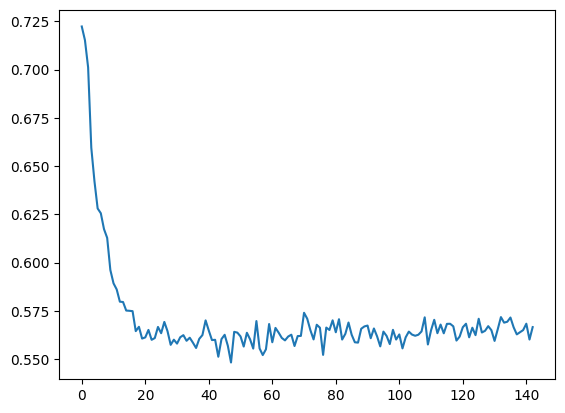

In [140]:
plt.plot(losses[0])

In [44]:
def test_random_evictor(requests: List[int], cache_size: int) -> TestResult:
    cache = set()
    misses = 0
    for r in tqdm.tqdm(requests):
        if len(cache) < cache_size:
            cache.add(r)
        elif r not in cache:
            evict_el = random.choice(list(cache))
            cache.remove(evict_el)
            misses += 1

            cache.add(r)
        assert len(cache) <= cache_size
    print(f"Misses: {misses}")


    return misses

test_random_evictor(requests, 16)

100%|██████████| 456266/456266 [00:00<00:00, 1828759.62it/s]

Misses: 180640


180640

In [39]:

def get_opt_for_test_dir(test_set_dir, page_size=16*1024, cache_size=8) -> TestResult:
    requests = []
    for volume_paths in sorted(test_set[test_set_dir]):
        for path in volume_paths:
            requests.extend(get_hwi_page_requests(get_reads(read_trace(path)), page_size=page_size))


    misses = opt_cache_simulation(requests, cache_size)

    return TestResult(
        cache_name="OPT",
        miss_count=misses,
        unique_addresses=len(set(requests)),
        trace_length=len(requests),
        execution_time=None
    )


In [40]:
import pandas as pd
import os

test_dirs = [
    #'1',
    #'2',
    '3',
    #'11',
    #'scenario_test_trace_simple/VDI_virus_scan'
]

def test_case(test_dir_name: str, cache: Cache, page_size=16*1024) -> TestResult:
    start_time = time.time()

    cache_factory = lambda: copy.deepcopy(cache)
    cache = cache_factory()
    requests = []
    total_misses = 0
    for i, volume_paths in enumerate(sorted(test_set[test_dir_name])):
        if test_dir_name == '3':
            if i != 0:
                continue

        for path in volume_paths:
            requests.extend(get_hwi_page_requests(get_reads(read_trace(path)), page_size=page_size))

    for r in tqdm.tqdm(requests):
        hit = cache.read(r)
        total_misses += int(not hit)


    return TestResult(
        cache_name=cache.name,
        miss_count=total_misses,
        unique_addresses=len(set(requests)),
        trace_length=len(requests),
        execution_time=round(time.time() - start_time, 3)
    )

def test(caches: List[Cache], test_dirs: List[str], cache_size, page_size=16*1024) -> pd.DataFrame:
    file_name = f'results_{page_size}_{cache_size}.csv'
    if os.path.exists(file_name):
        res = pd.read_csv(file_name, dtype={'test_dir': str}, index_col=0)
    else:
        res = pd.DataFrame()

    for test_dir in test_dirs:
        for cache in caches:

            if len(res) > 0 and len(res[(res['cache'] == cache.name) & (res['test_dir'] == test_dir)]) > 0:
                continue


            print("=======================================")
            print(f"Test dir: {test_dir}, cache: {cache.name}")
            print("=======================================")
            try:
                test_result = test_case(test_dir, cache, page_size=page_size)
            except Exception as exc:
                print("ERROR", exc)
                continue

            new_row = pd.DataFrame([{
                'test_dir': test_dir,
                'cache': cache.name,
                'miss_count': test_result.miss_count,
                'trace_length': test_result.trace_length,
                'unique_addresses': test_result.unique_addresses,
                'page_size': page_size,
                'execution_time': test_result.execution_time
            }])
            res = pd.concat([res, new_row])
            res.to_csv(file_name)

        if len(res) > 0 and len(res[(res['cache'] == 'OPT') & (res['test_dir'] == test_dir)]) > 0:
            continue

        opt_res = get_opt_for_test_dir(test_dir, page_size=page_size, cache_size=cache_size)
        new_row = pd.DataFrame([{
            'test_dir': test_dir,
            'cache': 'OPT',
            'miss_count': opt_res.miss_count,
            'trace_length': opt_res.trace_length,
            'unique_addresses': opt_res.unique_addresses,
            'page_size': page_size,
            'execution_time': opt_res.execution_time
        }])
        res = pd.concat([res, new_row])
        res.to_csv(file_name)

    res['miss_rate'] = res['miss_count'] / res['trace_length']
    res = res.sort_values(by=['test_dir', 'miss_rate'])

    return res


In [41]:

caches_size_16 = [
    Cache(
        "RandomEvictor",
        eviction_strategy=RandomEvictor(),
        size=16
    ),
    Cache(
        "LRU",
        eviction_strategy=LRU(),
        size=16
    ),
    Cache(
        "MQ",
        eviction_strategy=MQ(max_frequency=8, life_time=10, qout_size=8*4),
        size=16
    ),
    Cache(
        "DOM(FFM(n=10000,k=10,h=14))",
        eviction_strategy=DOM(prob_model=FFM(n=10000, k=10, h=14)),
        size=16
    ),
    Cache(
        "LRU + Markov(3)",
        eviction_strategy=LRU(),
        prefetch_strategy=Markov(3),
        size=16
    ),
    Cache(
        "LRU + NEXT",
        eviction_strategy=LRU(),
        prefetch_strategy=Next(),
        size=16
    ),
    Cache(
        "MQ + NEXT",
        eviction_strategy=MQ(max_frequency=8, life_time=10, qout_size=8*4),
        prefetch_strategy=Next(),
        size=16
    ),
    Cache(
        "MQ + Markov(3)",
        eviction_strategy=MQ(max_frequency=8, life_time=10, qout_size=8*4),
        prefetch_strategy=Markov(3),
        size=16
    ),
    Cache(
        "DOM(FFM(n=10000,k=10,h=14)) + NEXT",
        eviction_strategy=DOM(prob_model=FFM(n=1000, k=10, h=14)),
        prefetch_strategy=Next(),
        size=16
    ),
][:3]


In [43]:
test(caches_size_16, test_dirs, 16, page_size=16*1024)


KeyboardInterrupt: 

In [533]:

caches_size_64 = [
    Cache(
        "RandomEvictor",
        eviction_strategy=RandomEvictor(),
        size=64
    ),
    Cache(
        "LRU",
        eviction_strategy=LRU(),
        size=64
    ),
    Cache(
        "MQ",
        eviction_strategy=MQ(max_frequency=8, life_time=10, qout_size=8*4),
        size=64
    ),
    Cache(
        "LRU + NEXT",
        eviction_strategy=LRU(),
        prefetch_strategy=Next(),
        size=64
    ),
    Cache(
        "LRU + NEXT",
        eviction_strategy=LRU(),
        prefetch_strategy=Next(),
        size=64
    ),
    Cache(
        "LRU + Markov(3)",
        eviction_strategy=LRU(),
        prefetch_strategy=Markov(3),
        size=16
    ),
    Cache(
        "MQ + NEXT",
        eviction_strategy=MQ(max_frequency=8, life_time=10, qout_size=8*4),
        prefetch_strategy=Next(),
        size=64
    ),
    Cache(
        "MQ + Markov(3)",
        eviction_strategy=MQ(max_frequency=8, life_time=10, qout_size=8*4),
        prefetch_strategy=Markov(3),
        size=64
    ),
]
test(caches_size_64, test_dirs, 64, page_size=16*1024)


,test_dir,cache,miss_count,trace_length,unique_addresses,page_size,execution_time,miss_rate
0,1,OPT,961,61932,14281,16384,None,0.015517
0,1,MQ,48394,61932,14281,16384,9.215,0.781405
0,1,LRU,48415,61932,14281,16384,3.677,0.781744
0,1,RandomEvictor,48952,61932,14281,16384,3.942,0.790415
0,1,MQ + Markov(3),49298,61932,14281,16384,8.863,0.796002
0,1,MQ + NEXT,49328,61932,14281,16384,9.126,0.796486
0,1,LRU + NEXT,49363,61932,14281,16384,4.099,0.797052
0,1,LRU + Markov(3),51446,61932,14281,16384,4.332,0.830685
0,1,"DOM(FFM(n=10000,k=10,h=6))",52467,61932,14281,16384,2194.868,0.847171
0,1,"DOM(FFM(n=10000,k=10,h=6)) + NEXT",57120,61932,14281,16384,4587.174,0.922302


## Tests on smaller page sizes

In [ ]:

caches_size_16_smaller_pages = [
    Cache(
        "RandomEvictor",
        eviction_strategy=RandomEvictor(),
        size=16
    ),
    Cache(
        "LRU",
        eviction_strategy=LRU(),
        size=16
    ),
    Cache(
        "MQ",
        eviction_strategy=MQ(max_frequency=8, life_time=10, qout_size=8*4),
        size=16
    ),
    Cache(
        "LRU + Markov(3)",
        eviction_strategy=LRU(),
        prefetch_strategy=Markov(3),
        size=16
    ),
    Cache(
        "LRU + NEXT",
        eviction_strategy=LRU(),
        prefetch_strategy=Next(),
        size=16
    ),
    Cache(
        "MQ + NEXT",
        eviction_strategy=MQ(max_frequency=8, life_time=10, qout_size=8*4),
        prefetch_strategy=Next(),
        size=16
    ),
    Cache(
        "MQ + Markov(3)",
        eviction_strategy=MQ(max_frequency=8, life_time=10, qout_size=8*4),
        prefetch_strategy=Markov(3),
        size=16
    ),
]


### Page size - 512 Bytes

In [532]:
test(caches_size_64, test_dirs, 16, page_size=512)


,test_dir,cache,miss_count,trace_length,unique_addresses,page_size,execution_time,miss_rate
0,1,OPT,961,61932,41935,512,None,0.015517
0,1,MQ + Markov(3),51928,61932,41935,512,14.455,0.838468
0,1,MQ + NEXT,51956,61932,41935,512,14.73,0.838920
0,1,LRU + NEXT,51961,61932,41935,512,6.371,0.839001
0,1,LRU + Markov(3),53040,61932,41935,512,7.199,0.856423
0,1,LRU,53757,61932,41935,512,9.004,0.868000
0,1,MQ,53765,61932,41935,512,10.213,0.868130
0,1,RandomEvictor,54045,61932,41935,512,6.805,0.872651
0,11,OPT,209,57867,29936,512,None,0.003612
0,11,MQ + Markov(3),45893,57867,29936,512,15.915,0.793077
